In [8]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import plotly.express as px
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName("logicRegression").getOrCreate()

In [11]:
dados = spark.read.load('avioes/tudo_junto/ok2/dados.csv',format='csv',sep=',',inferSchema=True, header=True).limit(2000000)

In [15]:
dados.printSchema()
dados.show()
dados.count()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true

2000000

In [14]:
dados = dados.withColumn("Tem_DepDelay",
                         F.when(dados["DepDelay"]>15,1).otherwise(0))

dados = dados.withColumn("Tem_ArrDelay",
                         F.when(dados["ArrDelay"]>15,1).otherwise(0))

In [ ]:

categorical_cols = [
    "Operated_or_Branded_Code_Share_Partners",
    "Operating_Airline",
    "Origin",
    "Dest",
    "OriginCityNameState",
    "DestCityNameState"
]

numeric_cols = [
    "Year", "Quarter", "Month", "DayOfWeek", "Flight_Number_Operating_Airline",
    "CRSDepTime", "DepTime",
    "TaxiOut", "WheelsOff", "Distance", "DistanceGroup","AirTime",
    #"CRSArrTime", "ArrTime",
    "WheelsOn", "TaxiIn", "CRSElapsedTime",
    "ActualElapsedTime"
]

indexers = [StringIndexer(inputCol=c, outputCol=c + "_Index", handleInvalid="keep") for c in categorical_cols]
all_features = numeric_cols + [c + "_Index" for c in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")


lr = LogisticRegression(labelCol="Tem_ArrDelay", featuresCol="features")


pipeline = Pipeline(stages=indexers + [assembler, lr])


paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


evaluator = MulticlassClassificationEvaluator(
    labelCol="Tem_ArrDelay",
    predictionCol="prediction",
    metricName="accuracy"
)


tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,   # 80% train, 20% validation
    parallelism=1     # Prevents memory blowup
)


model = tvs.fit(dados)

In [19]:
# Make predictions on the test data
predictions = model.transform(dados)

# Select example rows to display
predictions.select("prediction", "Tem_ArrDelay", "features").show(5)


accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

# Calculate other metrics
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Tem_ArrDelay", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score = {f1_score}")

evaluator_weightedPrecision = MulticlassClassificationEvaluator(
    labelCol="Tem_ArrDelay", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator_weightedPrecision.evaluate(predictions)
print(f"Weighted Precision = {weighted_precision}")

evaluator_weightedRecall = MulticlassClassificationEvaluator(
    labelCol="Tem_ArrDelay", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = evaluator_weightedRecall.evaluate(predictions)
print(f"Weighted Recall = {weighted_recall}")

+----------+------------+--------------------+
|prediction|Tem_ArrDelay|            features|
+----------+------------+--------------------+
|       0.0|           0|[2022.0,2.0,5.0,2...|
|       0.0|           0|[2022.0,2.0,5.0,3...|
|       0.0|           0|[2022.0,2.0,5.0,7...|
|       0.0|           0|[2022.0,2.0,5.0,1...|
|       0.0|           0|[2022.0,2.0,5.0,2...|
+----------+------------+--------------------+
only showing top 5 rows

Test Accuracy = 0.828835
F1 Score = 0.776065254389705
Weighted Precision = 0.8252567773292612
Weighted Recall = 0.828835


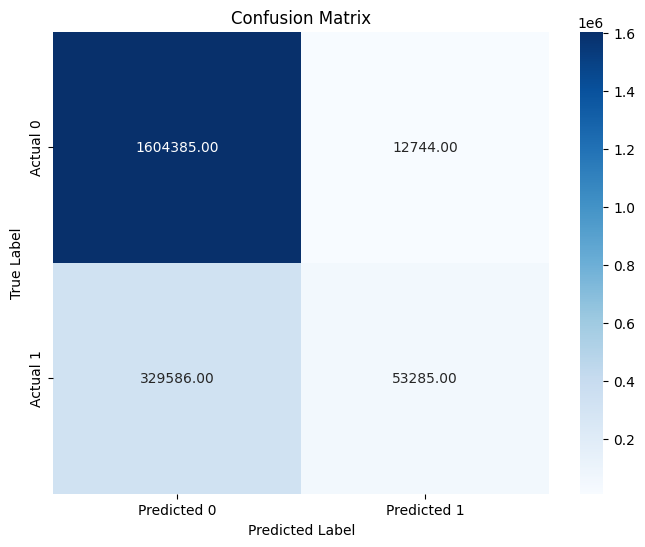

In [22]:

# Make predictions on the test data
predictions = model.transform(dados)

# Extract the true labels and predictions
true_labels = predictions.select("Tem_ArrDelay").rdd.flatMap(lambda x: x).collect()
pred_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Compute the confusion matrix
confusion_matrix = np.zeros((2, 2))
for true_label, pred_label in zip(true_labels, pred_labels):
    confusion_matrix[int(true_label)][int(pred_label)] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()